In [1]:
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import csv

In [2]:
# Possible emotion scores for each waypoint
emotion_scores = [0, 1, 5, 10]

# compareable values (high, medium, low)
compareable_values = [0, 5, 10]

# Weights for traffic value: 60% - 0, 30% - 5, 10% - 10
traffic_weights = [0.6, 0.3, 0.1]

# Weights for confort value: 10% - 0, 30% - 5, 60% - 10
comfort_weights = [0.1, 0.3, 0.6]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

#### Generating path features 

In [3]:

def generate_distance():
    # Define distance ranges
    ranges = {
        "low": range(10, 30),      # Low distance: 10 to 29
        "medium": range(30, 70),   # Medium distance: 30 to 69
        "high": range(70, 101)     # High distance: 70 to 100
    }
    # Assign weights: medium > low > high
    weights = [0.3, 0.6, 0.1]  # 30% low, 60% medium, 10% high

    # Select a range based on weights
    chosen_range = random.choices(list(ranges.values()), weights=weights, k=1)[0]

    # Generate a random distance from the chosen range
    return random.choice(chosen_range)


In [4]:
def generate_battery_level():
    # Define ranges and weights
    ranges = {
        "low": range(15, 40),       # 15 to 39
        "medium": range(40, 80),   # 40 to 79
        "high": range(80, 100)     # 80 to 99
    }
    weights = [0.1, 0.6, 0.3]  # 10% low, 60% medium, 30% high

    # Select a range based on weights
    chosen_range = random.choices(list(ranges.values()), weights=weights, k=1)[0]

    # Generate a random battery level from the chosen range
    return random.choice(chosen_range)


In [5]:

def calculate_waypoints(total_distance):
    # Define ranges based on total_distance
    low = max(1, total_distance // 18)    # Low waypoint density
    medium = max(1, total_distance // 14) # Medium waypoint density
    high = max(1, total_distance // 10)    # High waypoint density

    # Assign weights: medium > low > high
    weights = [0.5, 0.3, 0.2]  # 50% medium, 30% low, 20% high

    # Select the density type based on weights
    chosen_density = random.choices([low, medium, high], weights=weights, k=1)[0]

    return chosen_density


In [6]:
total_distance = generate_distance()
number_of_waypoints = calculate_waypoints(total_distance)
emotion_score = sum(random.choices(emotion_scores, k=number_of_waypoints))
comfort_score = sum(random.choices(compareable_values, weights=comfort_weights,k=number_of_waypoints))
traffic_score = sum(random.choices(compareable_values, weights=traffic_weights, k=number_of_waypoints))
battery_level = generate_battery_level()

print("Total Distance:", total_distance)
print("Number of Waypoints:", number_of_waypoints)
print("Emotion Score:", emotion_score)
print("Comfort Score:", comfort_score)
print("Traffic Score:", traffic_score)
print("Battery Level:", battery_level)

Total Distance: 34
Number of Waypoints: 1
Emotion Score: 5
Comfort Score: 10
Traffic Score: 0
Battery Level: 55


In [7]:

def generate_five_path_features():
    all_features = [] # List to store feature sets for all paths
    
    for _ in range(5):

        total_distance = generate_distance()
        number_of_waypoints = calculate_waypoints(total_distance)
        emotion_score = sum(random.choices(emotion_scores, k=number_of_waypoints))
        comfort_score = sum(random.choices(compareable_values, weights=comfort_weights,k=number_of_waypoints))
        traffic_score = sum(random.choices(compareable_values, weights=traffic_weights, k=number_of_waypoints))
        battery_level = generate_battery_level()

        # Append all features for the path to the feature set
        feature_set = np.array([total_distance, number_of_waypoints, emotion_score, comfort_score, traffic_score, battery_level])
        
        # Add the feature set to the list of all feature sets  
        all_features.append(feature_set)

    return np.vstack(all_features)       

In [8]:

# Normalize each feature (column) using Min-Max scaling
def normalize(data):
    # Initialize an empty list to hold the normalized data
    normalized_data = np.zeros_like(data, dtype=float)
    
    for i in range(data.shape[1]):
        feature_column = data[:, i]
        
        # If it's the battery level (the last column), divide by 100
        if i == data.shape[1] - 1:  # Check if the column is 'Batt'
            normalized_data[:, i] = feature_column / 100
        else:
            # Find the min and max of the feature column
            min_value = np.min(feature_column)
            max_value = np.max(feature_column)
            
            # Normalize the feature to the range [0, 1]
            if max_value > min_value:  # Avoid division by zero if all values are the same
                normalized_data[:, i] = (feature_column - min_value) / (max_value - min_value)
            else:
                normalized_data[:, i] = 0  # If all values are the same, assign 0 (or handle as needed)
    
    return normalized_data


In [9]:
def normalize_zscore(data):
    # Initialize an empty list to hold the normalized data
    normalized_data = np.zeros_like(data, dtype=float)
    
    for i in range(data.shape[1]):
        feature_column = data[:, i]
        
        # Calculate the mean and standard deviation of the feature column
        mean_value = np.mean(feature_column)
        std_value = np.std(feature_column)
        
        # Standardize the feature column (Z-score normalization)
        if std_value > 0:  # Avoid division by zero
            normalized_data[:, i] = (feature_column - mean_value) / std_value
        else:
            normalized_data[:, i] = 0  # If all values are the same, assign 0 (or handle as needed)
    
    return np.round(normalized_data, 4)

#### Custom Normalization

In [10]:
# Normalize each feature (column) using Min-Max scaling
def custom_normalization(features):
    # Initialize an empty list to hold the normalized data
    normalized_data = np.zeros_like(features, dtype=float)
    total_distance = features[0]
    num_of_wps = features[1]
    max_score  = num_of_wps*10
    max_num_of_wps = total_distance//10

    for i in range(6):
        feature_val = features[i]
        
        # If it's distance or the battery level, divide by 100
        if i == 0 or i == 5:
            normalized_data[i] = feature_val / 100
            
        elif i == 1:
            normalized_data[i] = feature_val / max_num_of_wps
        else:
                      
            # Normalize the feature to the range [0, 1]
            if max_score > 0:  # Avoid division by zero if all values are the same
                normalized_data[i] = feature_val / max_score
            else:
                normalized_data[i] = 0  # If all values are the same, assign 0 (or handle as needed)
    
    return np.round(normalized_data, 4)

def normalize_five_feature_sets(five_feature_sets):
    normalized_data = np.zeros_like(five_feature_sets, dtype=float)
    
    for i in range(5):
        feature_set = five_feature_sets[i]
        
        normalized_data[i] = custom_normalization(feature_set)
    
    return normalized_data

In [11]:
five_feature_sets = generate_five_path_features()
normalized_data = normalize_five_feature_sets(five_feature_sets)

# Reduced column names
columns = ["  Dist.", "Num Wps", "Emo Sco", "Comf Sc", "Traf Sc", "Batt lvl"]

# Print the header
print(" | ".join(columns))
print("-" * 60)

for row in five_feature_sets:
    print(" | ".join(f"{item:7}" for item in row))
print("-" * 60)

# Print each row of the data
for row in normalized_data:
    print(" | ".join(f"{item:7}" for item in row))
print("-" * 60)


  Dist. | Num Wps | Emo Sco | Comf Sc | Traf Sc | Batt lvl
------------------------------------------------------------
     36 |       2 |      11 |      20 |       5 |      74
     15 |       1 |       1 |       5 |       0 |      47
     66 |       3 |       6 |      30 |       0 |      59
     43 |       2 |      11 |      10 |       5 |      56
     92 |       9 |      41 |      65 |      25 |      17
------------------------------------------------------------
   0.36 |  0.6667 |    0.55 |     1.0 |    0.25 |    0.74
   0.15 |     1.0 |     0.1 |     0.5 |     0.0 |    0.47
   0.66 |     0.5 |     0.2 |     1.0 |     0.0 |    0.59
   0.43 |     0.5 |    0.55 |     0.5 |    0.25 |    0.56
   0.92 |     1.0 |  0.4556 |  0.7222 |  0.2778 |    0.17
------------------------------------------------------------


#### Calculating path scores

In [12]:

# Define the penalty or reward calculation for each feature
def calculate_distance_penalty(total_distance, battery_level):
    # Define how the distance and battery level affect the penalty
    # Assuming the battery level reduces penalty when higher
    return -4*(total_distance**2) * (1.1 - battery_level) # Example of distance penalty with battery adjustment

def calculate_waypoint_penalty(number_of_waypoints):
    # Negative log transformation for waypoints to penalize high waypoint count
    return -np.log(number_of_waypoints + 1)**3  # Penalty for each waypoint

def calculate_emotion_benefit(emotion_score):
    # If emotion_score is lower than 0.4, return a negative value
    if emotion_score < 0.4:
        return -(1.1-emotion_score)**2  # Penalty for lower emotion score
    else:
        return (emotion_score*1.5)  # Reward for higher emotion score

def calculate_comfort_benefit(comfort_score):
    # Comfort score is positive, so we give a benefit to higher comfort scores
    if comfort_score < 0.4:
        return -(1.1-comfort_score)  # Penalty for lower emotion score
    else:
        return  comfort_score # Reward for higher comfort score

def calculate_traffic_penalty(traffic_score):
    # Traffic score is penalized, so we penalize higher traffic scores
    return -2*traffic_score**2  # Exponential penalty for traffic, adjust factor as needed

def calculate_path_score(feature_set):
    total_distance, number_of_waypoints, emotion_score, comfort_score, traffic_score, battery_level = feature_set
    
    # Calculate the penalty or reward for each feature
    distance_penalty = calculate_distance_penalty(total_distance, battery_level)
    waypoint_penalty = calculate_waypoint_penalty(number_of_waypoints)
    emotion_benefit = calculate_emotion_benefit(emotion_score)
    comfort_benefit = calculate_comfort_benefit(comfort_score)
    traffic_penalty = calculate_traffic_penalty(traffic_score)
    
    # Combine all features using their respective weights
    score = (distance_penalty +
             waypoint_penalty +
             emotion_benefit +
             comfort_benefit +
             traffic_penalty)
    
    return np.round(score, 8)


#### Vsualizing path score vaiability

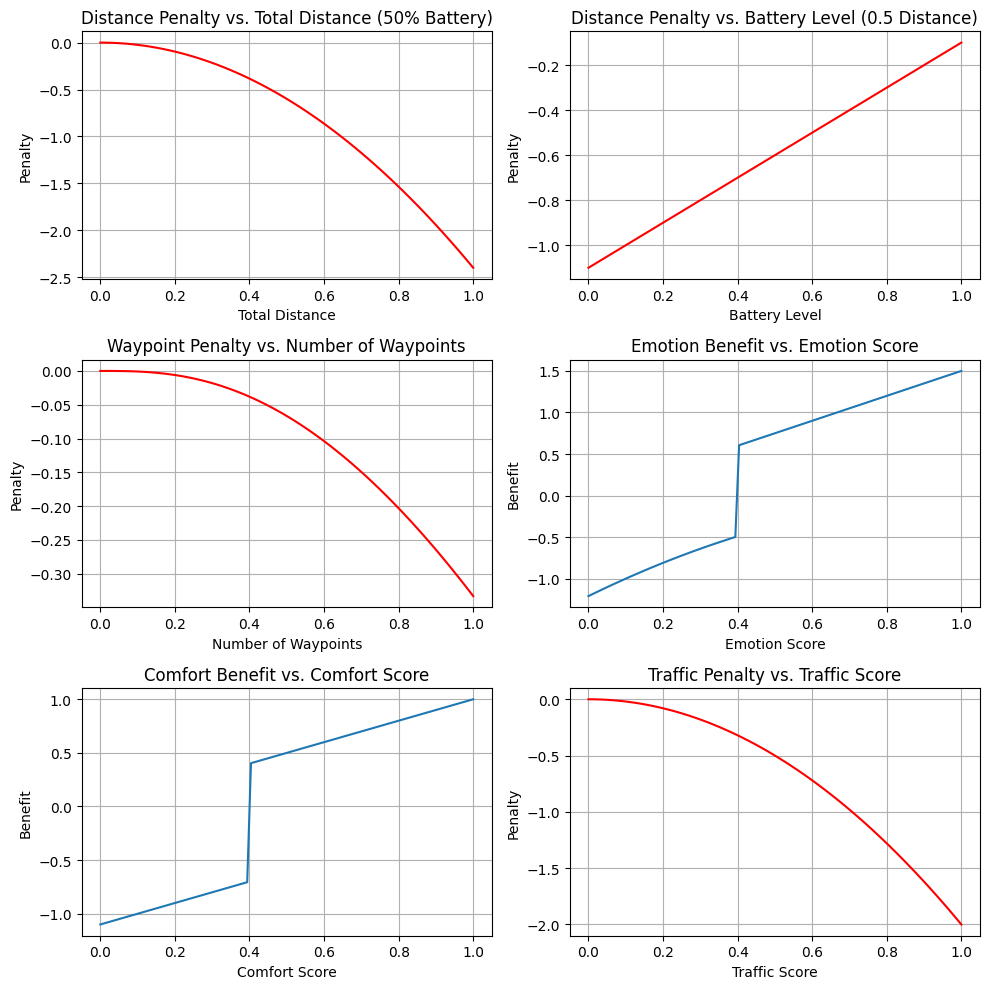

In [13]:

# Plot the penalty/reward over a range of values for each feature
val_range = np.linspace(0, 1, 100)

# 1. Distance penalty vs. total_distance (Fixed battery_level)
distance_penalties = [calculate_distance_penalty(d, 0.5) for d in val_range]  # Keep battery level fixed at 50%

# 2. Distance penalty vs. battery_level  (Fixed total_distance)
distance_penalties_battery = [calculate_distance_penalty(0.5, b) for b in val_range]  # Keep distance at 0.5

# 3. Waypoint penalty vs. number_of_waypoints
waypoint_penalties = [calculate_waypoint_penalty(w) for w in val_range]

# 4. Emotion benefit vs. emotion_score
emotion_benefits = [calculate_emotion_benefit(e) for e in val_range]

# 5. Comfort benefit vs. comfort_score
comfort_benefits = [calculate_comfort_benefit(c) for c in val_range]

# 6. Comfort benefit vs. comfort_score
traffic_penalties = [calculate_traffic_penalty(t) for t in val_range]

# Create the plots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot distance penalty
axs[0, 0].plot(val_range, distance_penalties, label='Distance Penalty with Distance', color="red")
axs[0, 0].set_title('Distance Penalty vs. Total Distance (50% Battery)')
axs[0, 0].set_xlabel('Total Distance')
axs[0, 0].set_ylabel('Penalty')
axs[0, 0].grid(True)

# Plot distance penalty
axs[0, 1].plot(val_range, distance_penalties_battery, label='Distance Penalty with Battery', color="red")
axs[0, 1].set_title('Distance Penalty vs. Battery Level (0.5 Distance)')
axs[0, 1].set_xlabel('Battery Level')
axs[0, 1].set_ylabel('Penalty')
axs[0, 1].grid(True)

# Plot waypoint penalty
axs[1, 0].plot(val_range, waypoint_penalties, label='Waypoint Penalty',  color="red")
axs[1, 0].set_title('Waypoint Penalty vs. Number of Waypoints')
axs[1, 0].set_xlabel('Number of Waypoints')
axs[1, 0].set_ylabel('Penalty')
axs[1, 0].grid(True)

# Plot emotion benefit
axs[1, 1].plot(val_range, emotion_benefits, label='Emotion Benefit')
axs[1, 1].set_title('Emotion Benefit vs. Emotion Score')
axs[1, 1].set_xlabel('Emotion Score')
axs[1, 1].set_ylabel('Benefit')
axs[1, 1].grid(True)

# Plot comfort benefit
axs[2, 0].plot(val_range, comfort_benefits, label='Comfort Benefit')
axs[2, 0].set_title('Comfort Benefit vs. Comfort Score')
axs[2, 0].set_xlabel('Comfort Score')
axs[2, 0].set_ylabel('Benefit')
axs[2, 0].grid(True)

# Plot traffic penalty
axs[2, 1].plot(val_range, traffic_penalties, label='Traffic Penalty',  color="red")
axs[2, 1].set_title('Traffic Penalty vs. Traffic Score')
axs[2, 1].set_xlabel('Traffic Score')
axs[2, 1].set_ylabel('Penalty')
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()

#### Mannually checking path scores

In [14]:
five_feature_sets = generate_five_path_features()
normalized_data = normalize_five_feature_sets(five_feature_sets)

# Reduced column names
columns = ["Dist", "Wpts", " Emo", "Comf", "Traf", "Batt"]

# Print the header
print(" | ".join(columns))
print("-" * 40)

# Print each row of the data
for row in five_feature_sets:
    print(" | ".join(f"{item:4}" for item in row))
print("-" * 40)

# Print path scores
for i in range(len(normalized_data)):
    print(f"Path {i+1} Score: {calculate_path_score(normalized_data[i])}")


Dist | Wpts |  Emo | Comf | Traf | Batt
----------------------------------------
  74 |    7 |   12 |   50 |   10 |   76
  38 |    3 |   15 |   20 |    5 |   84
  21 |    1 |   10 |   10 |    5 |   83
  95 |    9 |   15 |   75 |   10 |   97
  34 |    3 |   20 |   30 |    0 |   99
----------------------------------------
Path 1 Score: -1.26659943
Path 2 Score: 0.87792157
Path 3 Score: 1.88571274
Path 4 Score: -0.86475996
Path 5 Score: 1.61616135


### Comparing scores with different features

In [15]:
feature_set_1 = [23, 1, 10, 10, 0, 60]
feature_set_2 = [15, 1, 10, 10, 0, 64]

feature_set_1 = custom_normalization(feature_set_1)
feature_set_2 = custom_normalization(feature_set_2)

score_1 = calculate_path_score(feature_set_1)
score_2 = calculate_path_score(feature_set_2)

print(f'Path 1 Score: {score_1}\nPath 2 Score: {score_2}')

Path 1 Score: 2.32754074
Path 2 Score: 2.12557535


In [16]:
def generate_data():
    all_features = [] # List to store feature sets for all paths
    battery_level = generate_battery_level()
    
    for _ in range(5): 

        total_distance = generate_distance()
        number_of_waypoints = calculate_waypoints(total_distance)
        emotion_score = sum(random.choices(emotion_scores, k=number_of_waypoints))
        comfort_score = sum(random.choices(compareable_values, weights=comfort_weights,k=number_of_waypoints))
        traffic_score = sum(random.choices(compareable_values, weights=traffic_weights, k=number_of_waypoints))
        # battery_level = generate_battery_level()

        # Append all features for the path to the feature set
        feature_set = np.array([total_distance, number_of_waypoints, emotion_score, comfort_score, traffic_score, battery_level])
        
        # Add the feature set to the list of all feature sets  
        all_features.append(feature_set)
        
    return np.vstack(all_features)   

In [17]:
all_feature_sets = generate_data()
normalized_data = normalize_five_feature_sets(all_feature_sets)

# Reduced column names
columns = ["Dist", "Wpts", " Emo", "Comf", "Traf", "Batt"]

# Print the header
print(" | ".join(columns))
print("-" * 40)

# Print each row of the data
for row in all_feature_sets:
    print(" | ".join(f"{item:4}" for item in row))
print("-" * 40)

# Print path scores
scores = []
for i in range(len(normalized_data)):
    score = calculate_path_score(normalized_data[i])
    scores.append(score)
    print(f"Path {i+1} Score: {score}")

Dist | Wpts |  Emo | Comf | Traf | Batt
----------------------------------------
  28 |    2 |   15 |    5 |   15 |   43
  37 |    2 |   11 |   15 |    0 |   43
  31 |    2 |   10 |   10 |   10 |   43
  32 |    2 |    6 |   10 |    5 |   43
  69 |    4 |   10 |   20 |   15 |   43
----------------------------------------
Path 1 Score: -1.39313665
Path 2 Score: 1.07479607
Path 3 Score: 0.35914007
Path 4 Score: -0.67274393
Path 5 Score: -1.91300993


#### Generating a dataset to train LambdaMART 

In [18]:
def generate_dataset():
    all_features = [] # List to store feature sets for all paths
    battery_level = generate_battery_level()
    
    for _ in range(5): 

        total_distance = generate_distance()
        number_of_waypoints = calculate_waypoints(total_distance)
        emotion_score = sum(random.choices(emotion_scores, k=number_of_waypoints))
        comfort_score = sum(random.choices(compareable_values, weights=comfort_weights,k=number_of_waypoints))
        traffic_score = sum(random.choices(compareable_values, weights=traffic_weights, k=number_of_waypoints))
        
        # Append all features for the path to the feature set
        feature_set = np.array([total_distance, number_of_waypoints, emotion_score, comfort_score, traffic_score, battery_level])
        
        feature_set = custom_normalization(feature_set)
        
        path_score = calculate_path_score(feature_set)
        
        feature_set = np.append(feature_set, path_score)
        
        # Add the feature set to the list of all feature sets  
        all_features.append(feature_set)
        
    return np.vstack(all_features)

In [19]:
def add_relevance_column(query_set):
    # Rank the rows by their scores in descending order
    sorted_indices = np.argsort(query_set[:, -1])[::-1]  # Sort in descending order
    
    # Create a relevance array where the highest score gets 1 and the lowest gets 5
    relevance = np.zeros(query_set.shape[0], dtype=int)
    relevance[sorted_indices] = np.arange(1, query_set.shape[0] + 1)
    
    # Add the relevance column to the query_set
    query_set_with_relevance = np.column_stack((query_set, relevance))
    
    return query_set_with_relevance

In [20]:
query_set = generate_dataset()
print(query_set)

print("-" * 40)

query_set_with_relevance = add_relevance_column(query_set)

for i in range(len(query_set_with_relevance)):
    print(f'score: {query_set_with_relevance[i][6]}, relevence: {query_set_with_relevance[i][7]}')

[[ 0.48        1.          0.275       0.875       0.25        0.56
  -0.76131365]
 [ 0.52        0.6         0.3333      0.8333      0.          0.56
  -0.4424183 ]
 [ 0.11        1.          1.          0.5         1.          0.56
  -0.35916065]
 [ 0.18        1.          0.1         1.          0.5         0.56
  -0.90300865]
 [ 0.45        0.5         0.1         0.5         0.          0.56
  -1.00405926]]
----------------------------------------
score: -0.76131365, relevence: 3.0
score: -0.4424183, relevence: 2.0
score: -0.35916065, relevence: 1.0
score: -0.90300865, relevence: 4.0
score: -1.00405926, relevence: 5.0


In [ ]:

# Create the file path for CSV
file_path = 'test_data_large.csv'

# Write the CSV
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Writing the header
    writer.writerow(['Query', 'Batt', 'Dist', 'Wpts', 'Emot', 'Comf', 'Traf', 'Score', 'Relev'])
    
    for quary_num in range(10000):
        query_fset = generate_dataset()
        query_set_with_rel = add_relevance_column(query_fset)
        
        for feature_set in range(5):
            writer.writerow([quary_num+1] + query_set_with_rel[feature_set].tolist())
    
print(f"CSV file '{file_path}' has been created.")
